In [1]:
using Flux
using Plots

In [2]:
function loss_mse(model, features, labels)
    y_hat = model(features)
    return Flux.mse(y_hat, labels)
end

loss_mse (generic function with 1 method)

In [3]:
function loss_lasso(model, features, labels; lambda=0.01)
    y_hat = model(features)
    mse_loss = Flux.mse(y_hat, labels)
    l1_penalty = lambda * sum(abs.(model.weight))
    return mse_loss + l1_penalty
end

loss_lasso (generic function with 1 method)

In [4]:
function loss_ridge(model, features, labels; lambda=0.01)
    y_hat = model(features)
    mse_loss = Flux.mse(y_hat, labels)
    l2_penalty = lambda * sum(model.weight .^ 2)
    return mse_loss + l2_penalty
end

loss_ridge (generic function with 1 method)

In [5]:
function loss_elastic_net(model, features, labels; lambda1=0.01, lambda2=0.01)
    y_hat = model(features)
    mse_loss = Flux.mse(y_hat, labels)
    l1_penalty = lambda1 * sum(abs.(model.weight))
    l2_penalty = lambda2 * sum(model.weight .^ 2)
    return mse_loss + l1_penalty + l2_penalty
end

loss_elastic_net (generic function with 1 method)

In [6]:
function train_model!(loss, model, features, labels; learning_rate=0.01)
    dLdm, _, _ = gradient(loss, model, features, labels)
    @. model.weight = model.weight - learning_rate * dLdm.weight
    @. model.bias = model.bias - learning_rate * dLdm.bias
end

function train_model!(loss, model, data; learning_rate=0.01)
    Flux.train!(loss, model, data, Descent(learning_rate))
end

train_model! (generic function with 2 methods)

In [7]:
function train_until_converged!(loss, model, data; max_epochs=10000, tolerance=1e-4, learning_rate=0.01)
    x = hcat([d[1] for d in data]...)
    y = hcat([d[2] for d in data]...)
    loss_prev = Inf
    for epoch in 1:max_epochs
        train_model!(loss, model, data; learning_rate=learning_rate)
        current_loss = loss(model, x, y)

        if loss_prev == Inf
            loss_prev = current_loss
            continue
        end

        if current_loss < 1 && abs(loss_prev - current_loss) < tolerance
            println("Converged at epoch $epoch with loss $current_loss")
            break
        end
        loss_prev = current_loss
    end
end

train_until_converged! (generic function with 1 method)

In [8]:
data = [([x + rand(Float32)], 3x + 5 + rand(Float32)) for x in -3:0.1f0:3]
x = hcat([d[1] for d in data]...)
y = hcat([d[2] for d in data]...)

1×61 Matrix{Float32}:
 -3.88961  -2.71484  -2.58005  …  13.2869  13.6187  14.1521  14.3514

In [9]:
loss = (model, x, y) -> loss_mse(model, x, y)
model = Flux.Dense(1 => 1)
train_until_converged!(loss, model, data; tolerance=1e-6)
predicted_values = model(x)

Converged at epoch 13 with loss 0.8693087


1×61 Matrix{Float32}:
 -3.19595  -2.35053  -1.27298  …  14.3388  12.6528  14.2047  14.1969

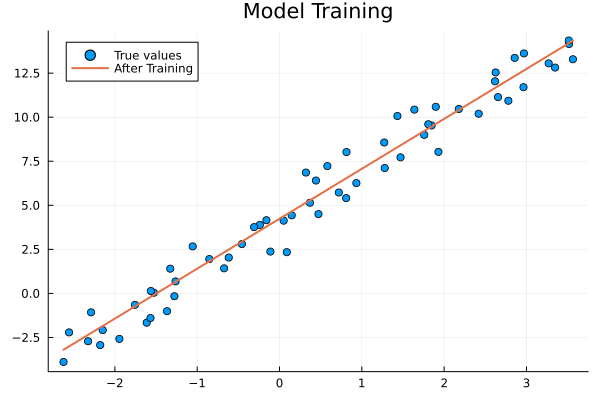

In [10]:
plot(vec(x), vec(y), seriestype = :scatter, label="True values", title="Model Training")
plot!((x) -> model.bias[1] + model.weight[1] * x, label="After Training", lw=2)

In [11]:
Flux.params(model)

Params([Float32[2.833506;;], Float32[4.238827]])

In [12]:
f(x) = 3x[1] + 2x[2] - x[3] + 4x[4] - 2x[5] + 1
data = []
for i in 1:100
    xi = [rand(Float32), rand(Float32), rand(Float32), rand(Float32), rand(Float32)]
    yi = f(xi) + rand(Float32)
    push!(data, (xi, yi))
end
x = hcat([d[1] for d in data]...)
y = hcat([d[2] for d in data]...)

1×100 Matrix{Float32}:
 4.52046  4.97725  3.63472  2.65694  …  3.70277  2.40673  4.38669  4.1908

In [13]:
loss = (model, x, y) -> loss_mse(model, x, y)
model = Flux.Dense(5 => 1)
train_until_converged!(loss, model, data; tolerance=1e-6)
predicted_values = model(x)

Converged at epoch 46 with loss 0.079036936


1×100 Matrix{Float32}:
 4.1783  4.59231  3.37089  3.06699  …  3.38391  2.39747  4.05413  4.59283

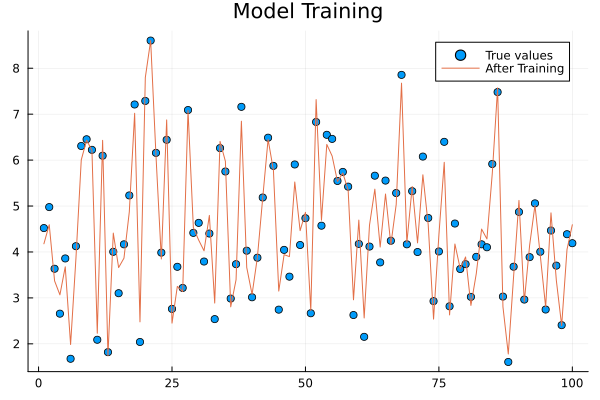

In [14]:
plot(1:100, y[1, :], seriestype = :scatter, label="True values", title="Model Training")
plot!(1:100, predicted_values[1, :], label="After Training")

In [15]:
Flux.params(model)

Params([Float32[2.8424895 1.8121127 … 4.213126 -2.0494735], Float32[1.645331]])